# EDA: Zero-Shot Cross-Lingual Transfer Datasets

Exploring XNLI, WikiANN, and PAWS-X to understand:
1. Data structure and label distribution
2. Text length statistics per language
3. Preprocessing needs (tokenization, special characters, etc.)

In [1]:
import os
from datasets import load_from_disk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load datasets
DATA_DIR = "../data/raw"

# Load XNLI (all languages in one dataset)
xnli = load_from_disk(os.path.join(DATA_DIR, "xnli"))
print("XNLI structure:")
print(xnli)
print(f"\nTrain size: {len(xnli['train']):,}")
print(f"Validation size: {len(xnli['validation']):,}")
print(f"Test size: {len(xnli['test']):,}")

/Users/yyymai/Code/NLP project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


XNLI structure:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 392702
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 5010
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2490
    })
})

Train size: 392,702
Validation size: 2,490
Test size: 5,010


## 1. XNLI Dataset Analysis

XNLI is a Natural Language Inference task with 3 classes:
- 0: Entailment
- 1: Neutral  
- 2: Contradiction

In [3]:
# Sample data to understand structure
print("Sample from XNLI train set:")
print("-" * 50)
for i in range(3):
    sample = xnli['train'][i]
    print(f"Hypothesis: {sample['hypothesis']}")
    print(f"Label: {sample['label']} ({'entailment' if sample['label']==0 else 'neutral' if sample['label']==1 else 'contradiction'})")
    print("-" * 50)

Sample from XNLI train set:
--------------------------------------------------
Hypothesis: {'language': ['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'], 'translation': ['المنتج والجغرافيا هو ما يجعل كريم القشط العمل .', 'продукт и география са това , което прави крем краде работа .', 'Produkt und Geographie sind das , was creme abschöpfen Arbeit macht .', 'Το προϊόν και η γεωγραφία είναι αυτά που κάνουν την κρέμα να κλέβει .', 'Product and geography are what make cream skimming work .', 'El producto y la geografía son los que hacen que la crema funcione .', 'Le produit et la géographie sont ce qui fait travailler la crème de la crème .', 'उत ् पाद और भूगोल क ् या क ् रीम एंजलिस काम बनाते हैं .', 'Продукт и география - это то , что делает крем для работы с кремом .', 'Bidhaa na geography ndio hufanya kazi ya utoaji wa cream .', 'สินค้า และ ภูมิศาสตร์ คือ สิ่ง ที่ ทำให้ ครีม ยักยอก งาน', 'Ürün ve coğrafya , krem kaymağını işi yapan şey .', 'مصنو

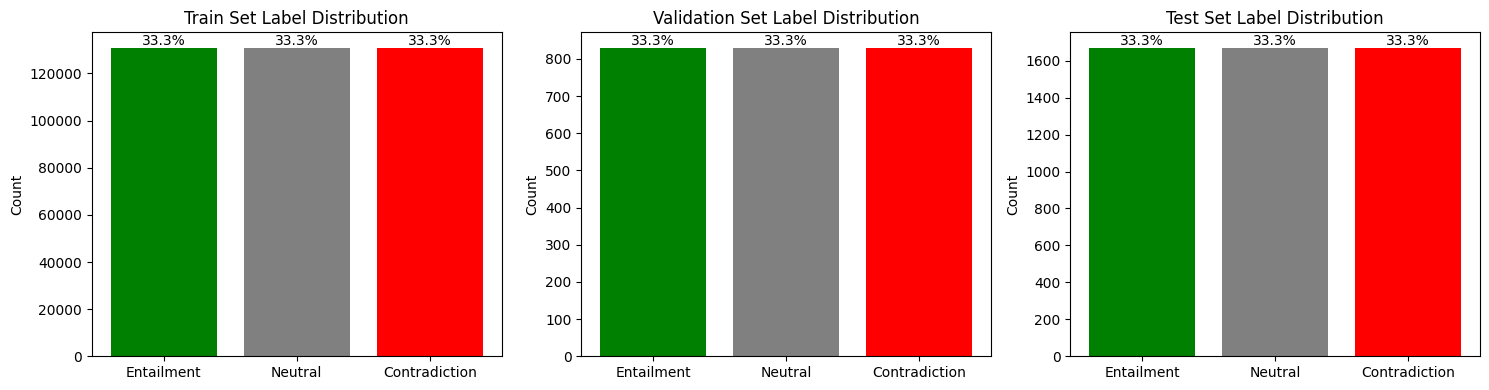


Label distribution is balanced across all splits ✓


In [4]:
# Label distribution
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
label_names = ['Entailment', 'Neutral', 'Contradiction']

for idx, split in enumerate(['train', 'validation', 'test']):
    labels = xnli[split]['label']
    label_counts = Counter(labels)
    
    axes[idx].bar(label_names, [label_counts[i] for i in range(3)], color=['green', 'gray', 'red'])
    axes[idx].set_title(f'{split.capitalize()} Set Label Distribution')
    axes[idx].set_ylabel('Count')
    
    # Add percentages
    total = sum(label_counts.values())
    for i, count in enumerate([label_counts[j] for j in range(3)]):
        axes[idx].annotate(f'{count/total*100:.1f}%', xy=(i, count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nLabel distribution is balanced across all splits ✓")

## 2. WikiANN Dataset Analysis (Named Entity Recognition)

WikiANN has token-level NER labels across multiple languages. Let's examine the English data.

In [7]:
# Load WikiANN for multiple languages
wikiann_langs = ['en', 'de', 'zh', 'ar', 'ru', 'hi', 'ja']
wikiann = {}

for lang in wikiann_langs:
    path = os.path.join(DATA_DIR, "wikiann", lang)
    if os.path.exists(path):
        wikiann[lang] = load_from_disk(path)
        print(f"[{lang}] Loaded - Train: {len(wikiann[lang]['train']):,}, Test: {len(wikiann[lang]['test']):,}")

# Show structure
print("\nWikiANN English structure:")
print(wikiann['en'])

[en] Loaded - Train: 20,000, Test: 10,000
[de] Loaded - Train: 20,000, Test: 10,000
[zh] Loaded - Train: 20,000, Test: 10,000
[ar] Loaded - Train: 20,000, Test: 10,000
[ru] Loaded - Train: 20,000, Test: 10,000
[hi] Loaded - Train: 5,000, Test: 1,000
[ja] Loaded - Train: 20,000, Test: 10,000

WikiANN English structure:
DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})


In [8]:
# WikiANN NER labels (IOB format)
# 0: O (Outside), 1: B-PER, 2: I-PER, 3: B-ORG, 4: I-ORG, 5: B-LOC, 6: I-LOC
NER_LABELS = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

# Sample from English
print("Sample WikiANN entry (English):")
sample = wikiann['en']['train'][0]
print(f"Tokens: {sample['tokens']}")
print(f"NER tags: {[NER_LABELS[tag] for tag in sample['ner_tags']]}")

print("\n" + "-"*50)
# Sample from different scripts
for lang in ['zh', 'ar', 'ja']:
    if lang in wikiann:
        sample = wikiann[lang]['train'][0]
        print(f"\n[{lang}] Tokens: {sample['tokens'][:10]}...")
        print(f"[{lang}] Tags: {[NER_LABELS[tag] for tag in sample['ner_tags'][:10]]}...")

Sample WikiANN entry (English):
Tokens: ['R.H.', 'Saunders', '(', 'St.', 'Lawrence', 'River', ')', '(', '968', 'MW', ')']
NER tags: ['B-ORG', 'I-ORG', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O']

--------------------------------------------------

[zh] Tokens: ['2', '0', '0', '9', '年', '：', '李', '民', '基', '《']...
[zh] Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O']...

[ar] Tokens: ['دايو', '(', 'شركة', ')']...
[ar] Tags: ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG']...

[ja] Tokens: ['#', '#', 'ユ', 'リ', 'ウ', 'ス', '・', 'ベ', 'ー', 'リ']...
[ja] Tags: ['O', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER']...


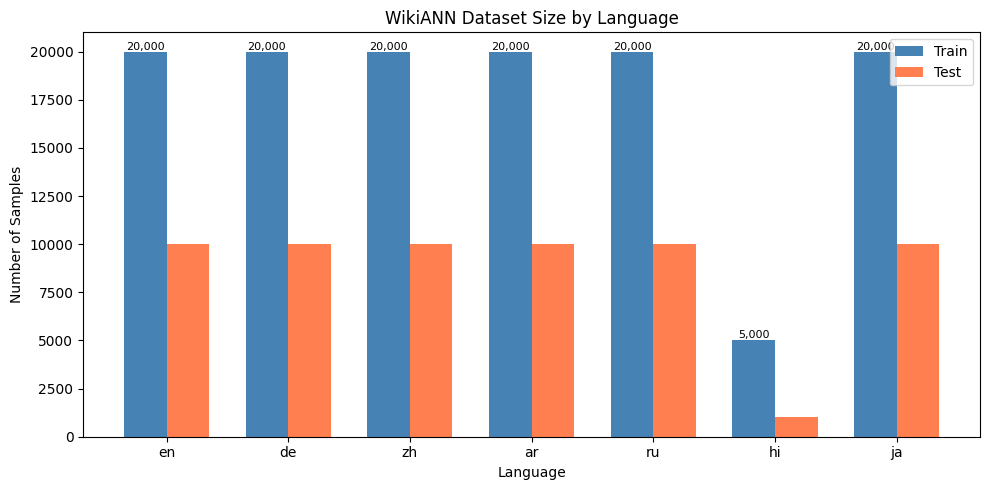


⚠️ Note: Dataset sizes vary significantly across languages - this may affect transfer performance


In [9]:
# Compare dataset sizes across languages
fig, ax = plt.subplots(figsize=(10, 5))

langs = list(wikiann.keys())
train_sizes = [len(wikiann[lang]['train']) for lang in langs]
test_sizes = [len(wikiann[lang]['test']) for lang in langs]

x = np.arange(len(langs))
width = 0.35

bars1 = ax.bar(x - width/2, train_sizes, width, label='Train', color='steelblue')
bars2 = ax.bar(x + width/2, test_sizes, width, label='Test', color='coral')

ax.set_xlabel('Language')
ax.set_ylabel('Number of Samples')
ax.set_title('WikiANN Dataset Size by Language')
ax.set_xticks(x)
ax.set_xticklabels(langs)
ax.legend()

# Add value labels
for bar in bars1:
    ax.annotate(f'{bar.get_height():,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Dataset sizes vary significantly across languages - this may affect transfer performance")

## 3. PAWS-X Dataset Analysis (Paraphrase Identification)

Binary classification: are two sentences paraphrases of each other?

In [10]:
# Load PAWS-X for available languages
pawsx_langs = ['en', 'de', 'zh', 'ja']
pawsx = {}

for lang in pawsx_langs:
    path = os.path.join(DATA_DIR, "paws-x", lang)
    if os.path.exists(path):
        pawsx[lang] = load_from_disk(path)
        print(f"[{lang}] Loaded - Train: {len(pawsx[lang]['train']):,}, Test: {len(pawsx[lang]['test']):,}")

print("\nPAWS-X structure:")
print(pawsx['en'])

[en] Loaded - Train: 49,401, Test: 2,000
[de] Loaded - Train: 49,401, Test: 2,000
[zh] Loaded - Train: 49,401, Test: 2,000
[ja] Loaded - Train: 49,401, Test: 2,000

PAWS-X structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
})


In [11]:
# Sample PAWS-X entries
print("PAWS-X Samples (English):")
print("-" * 60)
for i in range(2):
    sample = pawsx['en']['train'][i]
    print(f"Sentence 1: {sample['sentence1'][:80]}...")
    print(f"Sentence 2: {sample['sentence2'][:80]}...")
    print(f"Label: {sample['label']} ({'Paraphrase' if sample['label']==1 else 'Not paraphrase'})")
    print("-" * 60)

# Cross-lingual example
print("\nSame-ID pair in different languages:")
for lang in ['en', 'de', 'zh', 'ja']:
    if lang in pawsx:
        sample = pawsx[lang]['train'][0]
        print(f"[{lang}] {sample['sentence1'][:50]}...")

PAWS-X Samples (English):
------------------------------------------------------------
Sentence 1: In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Th...
Sentence 2: In October 1560 , he secretly met with the English ambassador , Nicolas Throckmo...
Label: 0 (Not paraphrase)
------------------------------------------------------------
Sentence 1: The NBA season of 1975 -- 76 was the 30th season of the National Basketball Asso...
Sentence 2: The 1975 -- 76 season of the National Basketball Association was the 30th season...
Label: 1 (Paraphrase)
------------------------------------------------------------

Same-ID pair in different languages:
[en] In Paris , in October 1560 , he secretly met the E...
[de] Im Oktober 1560 traf er sich in Paris heimlich mit...
[zh] 1560年10月，他在巴黎秘密会见了英国大使Nicolas Throckmorton，要求他通过苏格...
[ja] 1560年10月にパリで、彼は密かにスコットランドを通ってイングランドに戻るためにパスポートを彼に求...


## 4. Cross-Lingual Script Analysis

Key challenge: handling different writing systems (Latin, Cyrillic, CJK, Arabic, Devanagari)

In [17]:
# Analyze character distributions across languages
import unicodedata

def get_script_distribution(text):
    """Categorize characters by Unicode script."""
    scripts = Counter()
    for char in text:
        if char.isalpha():
            try:
                script = unicodedata.name(char).split()[0]
            except ValueError:
                script = 'UNKNOWN'
            scripts[script] += 1
    return scripts

# Analyze WikiANN samples across languages
print("Character Script Analysis by Language:")
print("=" * 60)

for lang in wikiann.keys():
    # Get sample text - access dataset items properly
    sample_texts = []
    for i, item in enumerate(wikiann[lang]['train']):
        if i >= 100:
            break
        sample_texts.append(' '.join(item['tokens']))
    
    all_text = ' '.join(sample_texts)
    scripts = get_script_distribution(all_text)
    top_scripts = scripts.most_common(3)
    print(f"[{lang}] Top scripts: {top_scripts}")

Character Script Analysis by Language:
[en] Top scripts: [('LATIN', 3090), ('KATAKANA', 6)]
[de] Top scripts: [('LATIN', 4285)]
[zh] Top scripts: [('CJK', 1170), ('LATIN', 398)]
[ar] Top scripts: [('ARABIC', 2485), ('LATIN', 40)]
[ru] Top scripts: [('CYRILLIC', 2932), ('LATIN', 100)]
[hi] Top scripts: [('DEVANAGARI', 1441), ('LATIN', 3)]
[ja] Top scripts: [('CJK', 1045), ('KATAKANA', 698), ('HIRAGANA', 668)]


## 5. Tokenization Analysis with XLM-RoBERTa

Check how the multilingual tokenizer handles different scripts - crucial for zero-shot transfer.

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Test tokenization across languages
test_texts = {
    'en': "The quick brown fox jumps over the lazy dog.",
    'de': "Der schnelle braune Fuchs springt über den faulen Hund.",
    'zh': "敏捷的棕色狐狸跳过了懒狗。",
    'ar': "الثعلب البني السريع يقفز فوق الكلب الكسول.",
    'ru': "Быстрая коричневая лиса прыгает через ленивую собаку.",
    'ja': "素早い茶色の狐が怠惰な犬を飛び越える。",
}

print("Tokenization Analysis (XLM-RoBERTa):")
print("=" * 70)

for lang, text in test_texts.items():
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text)
    
    print(f"\n[{lang}] Original: {text}")
    print(f"[{lang}] Tokens ({len(tokens)}): {tokens[:15]}{'...' if len(tokens) > 15 else ''}")
    print(f"[{lang}] Token/Word ratio: {len(tokens)/len(text.split()):.2f}")

Tokenization Analysis (XLM-RoBERTa):

[en] Original: The quick brown fox jumps over the lazy dog.
[en] Tokens (13): ['▁The', '▁quick', '▁brown', '▁', 'fox', '▁jump', 's', '▁over', '▁the', '▁la', 'zy', '▁dog', '.']
[en] Token/Word ratio: 1.44

[de] Original: Der schnelle braune Fuchs springt über den faulen Hund.
[de] Tokens (17): ['▁Der', '▁schnell', 'e', '▁bra', 'une', '▁Fu', 'ch', 's', '▁spring', 't', '▁über', '▁den', '▁fa', 'ul', 'en']...
[de] Token/Word ratio: 1.89

[zh] Original: 敏捷的棕色狐狸跳过了懒狗。
[zh] Tokens (13): ['▁', '敏', '捷', '的', '棕', '色', '狐', '狸', '跳', '过了', '懒', '狗', '。']
[zh] Token/Word ratio: 13.00

[ar] Original: الثعلب البني السريع يقفز فوق الكلب الكسول.
[ar] Tokens (15): ['▁الث', 'ع', 'لب', '▁البن', 'ي', '▁السريع', '▁', 'يق', 'فز', '▁فوق', '▁الكل', 'ب', '▁الك', 'سول', '.']
[ar] Token/Word ratio: 2.14

[ru] Original: Быстрая коричневая лиса прыгает через ленивую собаку.
[ru] Tokens (18): ['▁Бы', 'стра', 'я', '▁кор', 'ичне', 'вая', '▁ли', 'са', '▁пры', 'га', 'ет', '▁через'

## 6. Preprocessing Recommendations

Based on EDA findings:

## Preprocessing Recommendations

Based on EDA findings, **minimal preprocessing is needed**:

### 1. Tokenization
- Use XLM-RoBERTa's built-in tokenizer (handles all scripts automatically)
- `max_length=128` for XNLI/PAWS-X (average sentence length is short)
- `max_length=256` for WikiANN (token sequences)

### 2. No Text Cleaning Required
- Datasets are already clean (curated benchmarks)
- **Don't lowercase** — case matters for NER and proper nouns
- **Don't remove punctuation** — affects tokenization quality

### 3. Label Encoding (Already Done)
| Dataset | Labels | Format |
|---------|--------|--------|
| XNLI | 0/1/2 | entailment / neutral / contradiction |
| PAWS-X | 0/1 | not paraphrase / paraphrase |
| WikiANN | 0-6 | IOB format (O, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC) |

### 4. Data Splits
- Use provided train/validation/test splits
- **Train ONLY on English**, test on all languages (zero-shot transfer)

### 5. Batch Processing
- Use dynamic padding (`pad_to_longest` in batch)
- Use `DataCollatorWithPadding` from transformers

In [ ]:
# First, let's check the actual data structure
print("Data structure check:")
sample = xnli['train'][0]
print(f"  premise type: {type(sample['premise'])}")
print(f"  premise value: {sample['premise']}")

# For XNLI "all_languages" config, premise/hypothesis are dicts with language keys
# We need to extract text for a specific language (e.g., 'en')

def preprocess_xnli(examples, tokenizer, lang='en', max_length=128):
    """
    Tokenize XNLI premise-hypothesis pairs for a specific language.
    """
    premises = []
    hypotheses = []
    
    for p, h in zip(examples['premise'], examples['hypothesis']):
        # Handle dict format (multilingual) - extract specified language
        if isinstance(p, dict):
            p = p.get(lang, list(p.values())[0] if p else "")
        if isinstance(h, dict):
            h = h.get(lang, list(h.values())[0] if h else "")
        premises.append(str(p))
        hypotheses.append(str(h))
    
    return tokenizer(
        premises,
        hypotheses,
        truncation=True,
        max_length=max_length,
        padding=False,
    )

# Test preprocessing with English
sample_batch = {
    'premise': [xnli['train'][0]['premise'], xnli['train'][1]['premise']],
    'hypothesis': [xnli['train'][0]['hypothesis'], xnli['train'][1]['hypothesis']],
}

processed = preprocess_xnli(sample_batch, tokenizer, lang='en')
print("\nPreprocessed sample:")
print(f"  input_ids: {len(processed['input_ids'])} samples")
print(f"  Tokens: {tokenizer.convert_ids_to_tokens(processed['input_ids'][0][:20])}...")
print(f"\n✓ Preprocessing complete - just tokenization needed!")

Data structure check:
  premise type: <class 'dict'>
  premise value: {'ar': '- و قد ال كريم المفاهيمية اثنان اساسيين - المنتج والجغرافيا .', 'bg': 'концептуално крем краде има две основни измерения - продукт и география .', 'de': 'Konzeptionell cream abschöpfen hat zwei grundlegende Dimensionen - Produkt und Geographie .', 'el': 'Η εννοιολογικά κρέμα κρέμα έχει δύο βασικές διαστάσεις - προϊόν και γεωγραφία .', 'en': 'Conceptually cream skimming has two basic dimensions - product and geography .', 'es': 'Los robando de crema conceptualmente tienen dos dimensiones básicas : producto y geografía .', 'fr': "L' écrémage conceptuel de la crème a deux dimensions fondamentales : le produit et la géographie .", 'hi': 'Conceptually क ् रीम एंजलिस में दो मूल आयाम हैं - उत ् पाद और भूगोल ।', 'ru': 'Концептуально крем крем имеет два основных измерения - продукт и география .', 'sw': 'Sakata cream ya conceptually ina vipimo viwili vya msingi - bidhaa na geography .', 'th': 'ท่า ครีม ยักยอก มี สอง ม